# Behavioral Clustering and Chronic Disease Analysis
BRFSS Sample Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)


df = pd.read_csv(
    "BRFSS.csv",
    low_memory=False,
    usecols=[
        "weight2",
        "height3",
        "smoke100",
        "exerany2",
        "alcday4",
        "menthlth",
        "bphigh6",
        "diabete4",
        "cvdinfr4",
        "cvdstrk3",
        "asthma3",
        "havarth4",
        "_bmi5",
        "_ageg5yr",
        "sexvar",
        "_racegr3",
        "income3",
        "chcscnc1",
        "chcocnc1",
        "cholmed3",
    ],
)
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (9999, 20)

First 5 rows:


,sexvar,menthlth,exerany2,bphigh6,cholmed3,cvdinfr4,cvdstrk3,asthma3,chcscnc1,chcocnc1,havarth4,diabete4,income3,weight2,height3,smoke100,alcday4,_racegr3,_ageg5yr,_bmi5
0,2,88,2,1,2.0,2,2,2,2,2,2,1,99.0,172.0,503.0,2.0,888.0,1.0,13,3047.0
1,2,88,1,1,1.0,2,2,2,2,2,1,3,99.0,132.0,409.0,2.0,888.0,1.0,13,2856.0
2,2,2,1,1,1.0,2,2,1,2,2,1,3,2.0,130.0,504.0,1.0,888.0,2.0,13,2231.0
3,2,88,1,3,2.0,2,2,2,1,1,1,3,99.0,170.0,506.0,2.0,888.0,1.0,12,2744.0
4,2,88,1,1,2.0,2,2,2,2,1,1,1,7.0,170.0,508.0,2.0,202.0,1.0,12,2585.0


## Data Preprocessing

### Check Initial Data Quality

In [2]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print("Missing values summary:")
missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

Missing values summary:


,Missing Values,Percentage
cholmed3,1351,13.511351
_bmi5,739,7.390739
alcday4,368,3.680368
smoke100,301,3.010301
height3,167,1.670167
weight2,148,1.480148
income3,120,1.200120
_racegr3,3,0.030003


### Preprocessing Anthropometric Measurements

In [3]:
def clean_weight(value):
    if pd.isna(value):
        return np.nan
    
    value = float(value)
    
    if 50 <= value <= 776:  # Weight in pounds
        return value
    elif value == 7777:  # Don't know/Not sure
        return np.nan
    elif 9023 <= value <= 9352:  # Weight in kilograms (convert to pounds)
        kg_value = value - 9000
        return kg_value * 2.20462  # Convert kg to pounds
    elif value == 9999:  # Refused
        return np.nan
    else:
        return np.nan

df['weight_lbs'] = df['weight2'].apply(clean_weight)

def clean_height(value):
    if pd.isna(value):
        return np.nan
    
    value = float(value)
    
    if 200 <= value <= 711:  # Height in feet/inches format
        feet = value // 100
        inches = value % 100
        total_inches = (feet * 12) + inches
        return total_inches
    elif value == 7777:  # Don't know/Not sure
        return np.nan
    elif 9061 <= value <= 9998:  # Height in centimeters
        cm_value = value - 9000
        return cm_value * 0.393701  # Convert cm to inches
    elif value == 9999:  # Refused
        return np.nan
    else:
        return np.nan

df['height_inches'] = df['height3'].apply(clean_height)

def clean_bmi(value):
    if pd.isna(value):
        return np.nan
    
    # BMI has 2 implied decimal places
    return value / 100

df['bmi'] = df['_bmi5'].apply(clean_bmi)

def calculate_bmi(row):
    if pd.notna(row['weight_lbs']) and pd.notna(row['height_inches']) and row['height_inches'] > 0:
        return (row['weight_lbs'] / (row['height_inches'] ** 2)) * 703
    else:
        return np.nan

# Calculate BMI for records with missing BMI but available height and weight
df['calculated_bmi'] = df.apply(calculate_bmi, axis=1)

# Use original BMI if available, otherwise use calculated BMI
df['final_bmi'] = df['bmi'].fillna(df['calculated_bmi'])

def categorize_bmi(bmi):
    if pd.isna(bmi):
        return np.nan
    elif bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['final_bmi'].apply(categorize_bmi)

print("BMI categories distribution:")
print(df['bmi_category'].value_counts(dropna=False))

BMI categories distribution:
bmi_category
Obese            3414
Overweight       3141
Normal weight    2594
NaN               681
Underweight       169
Name: count, dtype: int64


### Preprocessing Health Behavior Variables

In [4]:
def clean_smoking(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    if value == 1:
        return 'Yes'
    elif value == 2:
        return 'No'
    elif value in [7, 9]:  # Don't know or Refused
        return np.nan
    else:
        return np.nan

df['smoker'] = df['smoke100'].apply(clean_smoking)

def clean_exercise(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    if value == 1:
        return 'Yes'
    elif value == 2:
        return 'No'
    elif value in [7, 9]:  # Don't know or Refused
        return np.nan
    else:
        return np.nan

df['exercises'] = df['exerany2'].apply(clean_exercise)

def clean_alcohol(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    if 101 <= value <= 199:  # Days per week
        days_per_week = value - 100
        return days_per_week * (30/7)  # Convert to days per month (approx)
    elif 201 <= value <= 299:  # Days in past 30
        return value - 200
    elif value == 777:  # Don't know
        return np.nan
    elif value == 888:  # No drinks in past 30 days
        return 0
    elif value == 999:  # Refused
        return np.nan
    else:
        return np.nan

df['alcohol_days'] = df['alcday4'].apply(clean_alcohol)

def categorize_alcohol(days):
    if pd.isna(days):
        return np.nan
    elif days == 0:
        return 'Non-drinker'
    elif days <= 5:
        return 'Light drinker'
    elif days <= 15:
        return 'Moderate drinker'
    else:
        return 'Heavy drinker'

df['alcohol_category'] = df['alcohol_days'].apply(categorize_alcohol)

def clean_mental_health(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    if 1 <= value <= 30:  # Number of days
        return value
    elif value == 88:  # None
        return 0
    elif value in [77, 99]:  # Don't know or Refused
        return np.nan
    else:
        return np.nan

df['mental_health_days'] = df['menthlth'].apply(clean_mental_health)

print("Smoking status distribution:")
print(df['smoker'].value_counts(dropna=False))

print("\nExercise status distribution:")
print(df['exercises'].value_counts(dropna=False))

print("\nAlcohol consumption categories:")
print(df['alcohol_category'].value_counts(dropna=False))

Smoking status distribution:
smoker
No     5683
Yes    3953
NaN     363
Name: count, dtype: int64

Exercise status distribution:
exercises
Yes    7460
No     2517
NaN      22
Name: count, dtype: int64

Alcohol consumption categories:
alcohol_category
Non-drinker         4906
Light drinker       2319
Heavy drinker       1162
Moderate drinker    1133
NaN                  479
Name: count, dtype: int64


### Preprocessing Health Condition Variables

In [5]:
def clean_blood_pressure(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    if value == 1:
        return 'Yes'
    elif value == 2:
        return 'Yes, during pregnancy only'
    elif value == 3:
        return 'No'
    elif value == 4:
        return 'Borderline'
    elif value in [7, 9]:  # Don't know or Refused
        return np.nan
    else:
        return np.nan

df['high_blood_pressure'] = df['bphigh6'].apply(clean_blood_pressure)

def clean_diabetes(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    if value == 1:
        return 'Yes'
    elif value == 2:
        return 'Yes, during pregnancy only'
    elif value == 3:
        return 'No'
    elif value == 4:
        return 'Pre-diabetes'
    elif value in [7, 9]:  # Don't know or Refused
        return np.nan
    else:
        return np.nan

df['diabetes'] = df['diabete4'].apply(clean_diabetes)

def clean_heart_attack(value):
    """same for the asthma3, havarth4, and cvdstrk3"""
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    if value == 1:
        return 'Yes'
    elif value == 2:
        return 'No'
    elif value in [7, 9]:  # Don't know or Refused
        return np.nan
    else:
        return np.nan

df['heart_attack'] = df['cvdinfr4'].apply(clean_heart_attack)
df['asthma'] = df['asthma3'].apply(clean_heart_attack)
df['arthritis'] = df['havarth4'].apply(clean_heart_attack)
df['stroke'] = df['cvdstrk3'].apply(clean_heart_attack)
df['high_cholesterol'] = df['cholmed3'].apply(clean_heart_attack)
df['skin_cancer'] = df['chcscnc1'].apply(clean_heart_attack)
df['other_cancer'] = df['chcocnc1'].apply(clean_heart_attack)

print("High blood pressure status distribution:")
print(df['high_blood_pressure'].value_counts(dropna=False))

print("\nDiabetes status distribution:")
print(df['diabetes'].value_counts(dropna=False))

print("\nHeart attack history distribution:")
print(df['heart_attack'].value_counts(dropna=False))

High blood pressure status distribution:
high_blood_pressure
No                            5219
Yes                           4495
Yes, during pregnancy only     146
Borderline                     103
NaN                             36
Name: count, dtype: int64

Diabetes status distribution:
diabetes
No                            8289
Yes                           1438
Pre-diabetes                   167
Yes, during pregnancy only      83
NaN                             22
Name: count, dtype: int64

Heart attack history distribution:
heart_attack
No     9351
Yes     579
NaN      69
Name: count, dtype: int64


### Preprocessing Demographic Variables

In [6]:
def clean_age_category(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    age_categories = {
        1: '18-24',
        2: '25-29',
        3: '30-34',
        4: '35-39',
        5: '40-44',
        6: '45-49',
        7: '50-54',
        8: '55-59',
        9: '60-64',
        10: '65-69',
        11: '70-74',
        12: '75-79',
        13: '80+'
    }
    
    if value in age_categories:
        return age_categories[value]
    elif value == 14:  # Don't know/Refused/Missing
        return np.nan
    else:
        return np.nan

df['age_category'] = df['_ageg5yr'].apply(clean_age_category)

def clean_sex(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    if value == 1:
        return 'Male'
    elif value == 2:
        return 'Female'
    else:
        return np.nan

df['sex'] = df['sexvar'].apply(clean_sex)

def clean_race(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    race_categories = {
        1: 'White only, Non-Hispanic',
        2: 'Black only, Non-Hispanic',
        3: 'Other race only, Non-Hispanic',
        4: 'Multiracial, Non-Hispanic',
        5: 'Hispanic'
    }
    
    if value in race_categories:
        return race_categories[value]
    elif value == 9:  # Don't know/Refused
        return np.nan
    else:
        return np.nan

df['race_ethnicity'] = df['_racegr3'].apply(clean_race)

def clean_income(value):
    if pd.isna(value):
        return np.nan
    
    value = int(value)
    
    income_categories = {
        1: 'Less than $10,000',
        2: '$10,000 to less than $15,000',
        3: '$15,000 to less than $20,000',
        4: '$20,000 to less than $25,000',
        5: '$25,000 to less than $35,000',
        6: '$35,000 to less than $50,000',
        7: '$50,000 to less than $75,000',
        8: '$75,000 to less than $100,000',
        9: '$100,000 to less than $150,000',
        10: '$150,000 to less than $200,000',
        11: '$200,000 or more'
    }
    
    if value in income_categories:
        return income_categories[value]
    elif value in [77, 99]:  # Don't know or Refused
        return np.nan
    else:
        return np.nan

df['income_category'] = df['income3'].apply(clean_income)

print("Age category distribution:")
print(df['age_category'].value_counts(dropna=False))

print("\nSex distribution:")
print(df['sex'].value_counts(dropna=False))

print("\nRace/ethnicity distribution:")
print(df['race_ethnicity'].value_counts(dropna=False))

Age category distribution:
age_category
65-69    1115
70-74    1046
60-64    1007
55-59     804
75-79     768
50-54     760
80+       743
35-39     665
40-44     653
45-49     630
30-34     611
18-24     565
25-29     461
NaN       171
Name: count, dtype: int64

Sex distribution:
sex
Female    5363
Male      4636
Name: count, dtype: int64

Race/ethnicity distribution:
race_ethnicity
White only, Non-Hispanic         6782
Black only, Non-Hispanic         1308
Other race only, Non-Hispanic     989
Multiracial, Non-Hispanic         380
Hispanic                          339
NaN                               201
Name: count, dtype: int64


# Create Clean Dataset with Processed Variables

In [7]:
clean_df = df[[
    # Health Metrics
    'weight_lbs', 'height_inches', 'final_bmi', 'bmi_category',
    # Health Behaviors
    'smoker', 'exercises', 'alcohol_days', 'alcohol_category', 'mental_health_days',
    # Chronic Health Conditions
    'high_blood_pressure', 'diabetes', 'heart_attack', 'stroke', 'arthritis', 'asthma', 'high_cholesterol',
    'skin_cancer', 'other_cancer',
    # Demographics
    'age_category', 'sex', 'race_ethnicity', 'income_category'
]]

print("Clean dataset shape:", clean_df.shape)
clean_df.head()

Clean dataset shape: (9999, 22)


,weight_lbs,height_inches,final_bmi,bmi_category,smoker,exercises,alcohol_days,alcohol_category,mental_health_days,high_blood_pressure,diabetes,heart_attack,stroke,arthritis,asthma,high_cholesterol,skin_cancer,other_cancer,age_category,sex,race_ethnicity,income_category
0,172.0,63.0,30.47,Obese,No,No,0.0,Non-drinker,0.0,Yes,Yes,No,No,No,No,No,No,No,80+,Female,"White only, Non-Hispanic",NaN
1,132.0,57.0,28.56,Overweight,No,Yes,0.0,Non-drinker,0.0,Yes,No,No,No,Yes,No,Yes,No,No,80+,Female,"White only, Non-Hispanic",NaN
2,130.0,64.0,22.31,Normal weight,Yes,Yes,0.0,Non-drinker,2.0,Yes,No,No,No,Yes,Yes,Yes,No,No,80+,Female,"Black only, Non-Hispanic","$10,000 to less than $15,000"
3,170.0,66.0,27.44,Overweight,No,Yes,0.0,Non-drinker,0.0,No,No,No,No,Yes,No,No,Yes,Yes,75-79,Female,"White only, Non-Hispanic",NaN
4,170.0,68.0,25.85,Overweight,No,Yes,2.0,Light drinker,0.0,Yes,Yes,No,No,Yes,No,No,No,Yes,75-79,Female,"White only, Non-Hispanic","$50,000 to less than $75,000"


### Analyze Missing Values in Clean Dataset

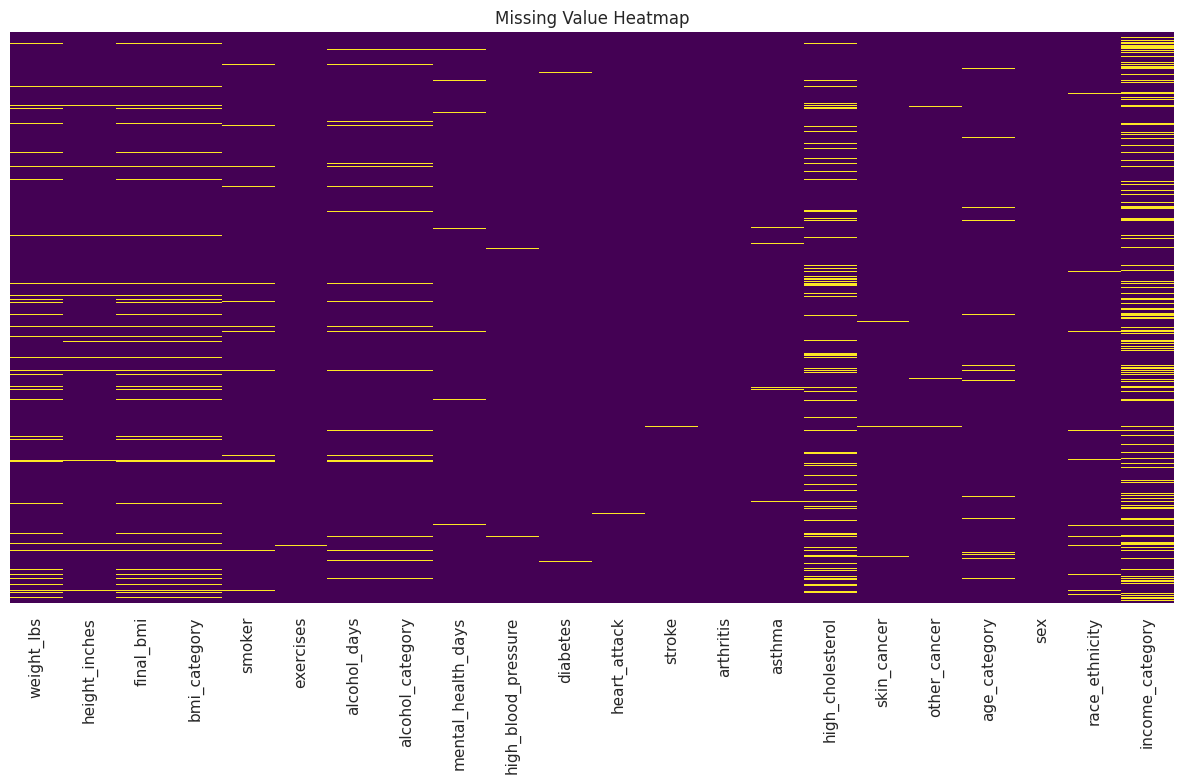

In [8]:
missing_clean = clean_df.isnull().sum()
missing_clean_pct = (clean_df.isnull().sum() / len(clean_df)) * 100

missing_clean_df = pd.DataFrame({
    'Missing Values': missing_clean,
    'Percentage': missing_clean_pct
})
missing_clean_df.sort_values('Percentage', ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(clean_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.tight_layout()
plt.show()

## EDA

### BMI Distribution

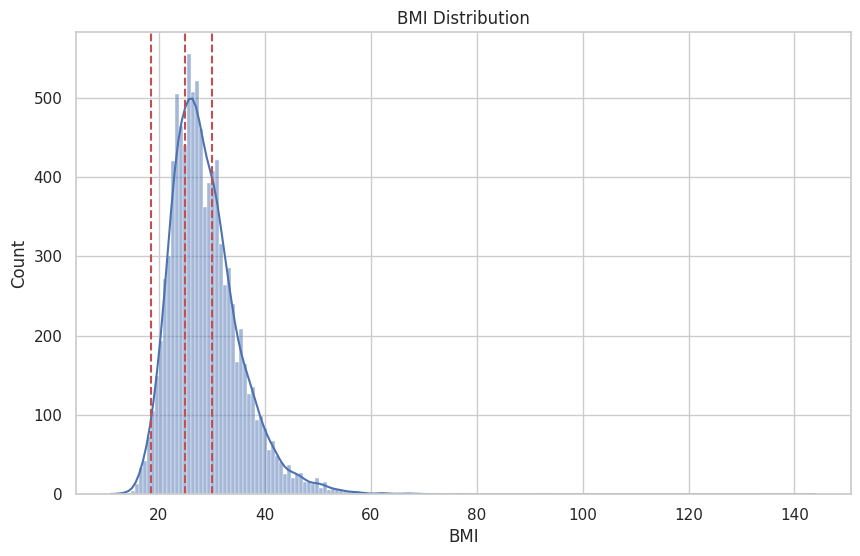

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=clean_df, x='final_bmi', kde=True)
plt.axvline(x=18.5, color='r', linestyle='--')
plt.axvline(x=25, color='r', linestyle='--')
plt.axvline(x=30, color='r', linestyle='--')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

is right-skewed (positively skewed), with most values concentrated between 18 and 40. The majority of individuals fall within the "Normal weight" (18.5–24.9), "Overweight" (25–29.9), and "Obese" (30+) categories. There are relatively few individuals with very high BMI values, but some extreme outliers exist.

### Prevalence of Health Conditions by Age Category

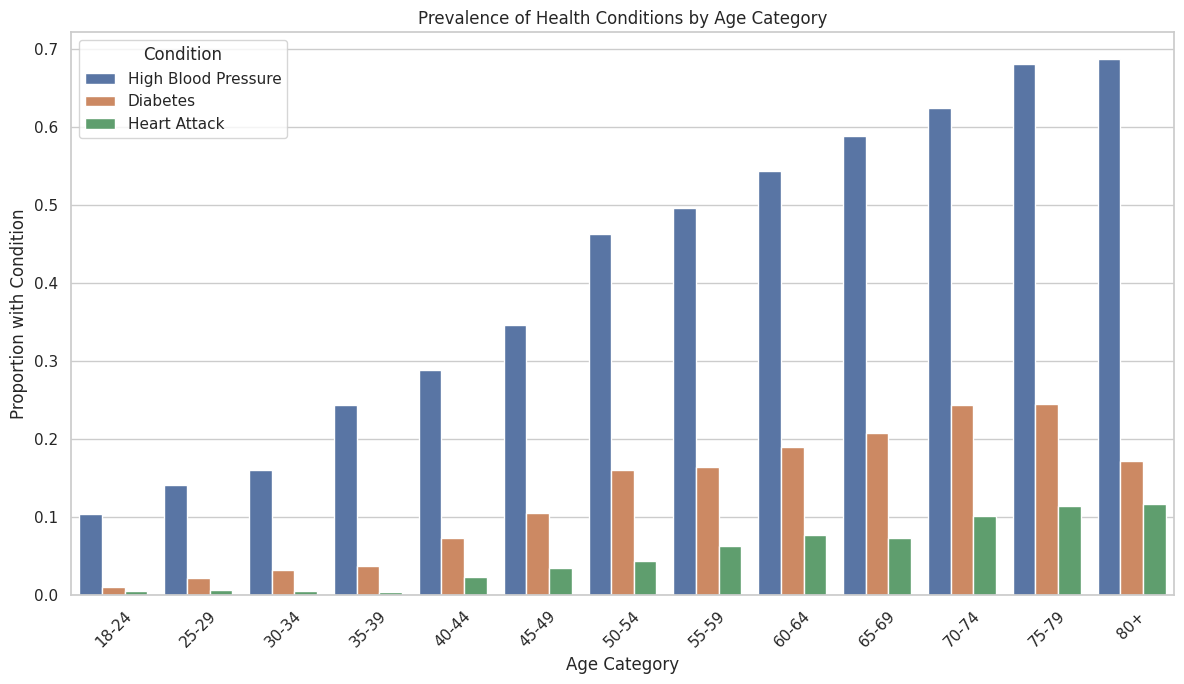

In [10]:
conditions = ['high_blood_pressure', 'diabetes', 'heart_attack']
condition_labels = {
    'high_blood_pressure': 'High Blood Pressure',
    'diabetes': 'Diabetes',
    'heart_attack': 'Heart Attack'
}

health_by_age = (
    clean_df.groupby('age_category')[conditions]
    .apply(lambda x: (x == 'Yes').mean())
    .reset_index()
    .melt(id_vars='age_category', var_name='Condition', value_name='Proportion')
)
health_by_age['Condition'] = health_by_age['Condition'].map(condition_labels)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=health_by_age,
    x='age_category',
    y='Proportion',
    hue='Condition'
)
plt.title('Prevalence of Health Conditions by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Proportion with Condition')
plt.legend(title='Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As you can see, the plot shows that the prevalence of high blood pressure, diabetes, and heart attack all increase with age. High blood pressure rises most sharply, affecting nearly 70% of those 80 and older. Diabetes and heart attack are less common but also show a clear upward trend with age.

### Health behaviors relationship

<Figure size 1000x600 with 0 Axes>

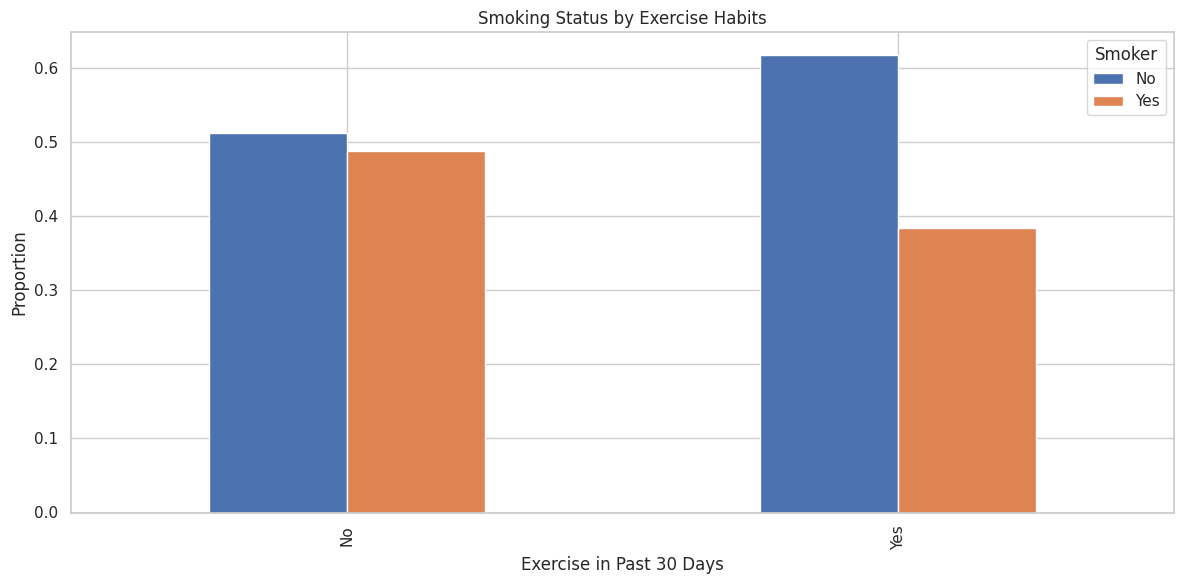

In [11]:
exercise_smoking = pd.crosstab(
    clean_df['exercises'],
    clean_df['smoker'],
    normalize='index'
)
plt.figure(figsize=(10, 6))
exercise_smoking.plot(kind='bar')
plt.title('Smoking Status by Exercise Habits')
plt.xlabel('Exercise in Past 30 Days')
plt.ylabel('Proportion')
plt.legend(title='Smoker')
plt.tight_layout()
plt.show()

This indicates that there is a clear association between regular exercise and lower smoking rates.

## data preparation

In [12]:
cluster_df = clean_df.copy()

cluster_df["exercise"] = cluster_df["exercises"].map({"Yes": 1, "No": 0})
cluster_df["smoking"] = cluster_df["smoker"].map({"Yes": 1, "No": 0})
cluster_df["female"] = cluster_df["sex"].map({"Female": 1, "Male": 0})

age_mapping = {
    "18-24": 21,
    "25-29": 27,
    "30-34": 32,
    "35-39": 37,
    "40-44": 42,
    "45-49": 47,
    "50-54": 52,
    "55-59": 57,
    "60-64": 62,
    "65-69": 67,
    "70-74": 72,
    "75-79": 77,
    "80+": 85,
}
cluster_df["age_numeric"] = cluster_df["age_category"].map(age_mapping)

income_order = [
    "Less than $10,000",
    "$10,000 to less than $15,000",
    "$15,000 to less than $20,000",
    "$20,000 to less than $25,000",
    "$25,000 to less than $35,000",
    "$35,000 to less than $50,000",
    "$50,000 to less than $75,000",
    "$75,000 to less than $100,000",
    "$100,000 to less than $150,000",
    "$150,000 to less than $200,000",
    "$200,000 or more",
]
income_map = {income: i + 1 for i, income in enumerate(income_order)}
cluster_df["income_level"] = cluster_df["income_category"].map(income_map)

# one-hot encoding categorical variables
race_dummies = pd.get_dummies(cluster_df["race_ethnicity"], prefix="race")
cluster_df = pd.concat([cluster_df, race_dummies], axis=1)

alcohol_map = {"Non-drinker": 0, "Light drinker": 1, "Moderate drinker": 2, "Heavy drinker": 3}
cluster_df["alcohol_level"] = cluster_df["alcohol_category"].map(alcohol_map)

clustering_features = [
    "final_bmi",
    "mental_health_days",
    "exercise",
    "smoking",
    "alcohol_level",
    "age_numeric",
    "female",
    "income_level",
    "race_White only, Non-Hispanic",
    "race_Black only, Non-Hispanic",
    "race_Other race only, Non-Hispanic",
    "race_Multiracial, Non-Hispanic",
    "race_Hispanic",
]

cluster_ready_df = cluster_df[clustering_features].copy()

cluster_ready_df_dropna = cluster_ready_df.dropna()
print(
    f"Complete cases: {len(cluster_ready_df_dropna)} out of {len(cluster_ready_df)} ({len(cluster_ready_df_dropna)/len(cluster_ready_df)*100:.2f}%)"
)

numeric_cols = ["final_bmi", "mental_health_days", "alcohol_level", "age_numeric", "income_level"]

imputer = SimpleImputer(strategy="median")
cluster_ready_df_imputed = pd.DataFrame(imputer.fit_transform(cluster_ready_df), columns=cluster_ready_df.columns)

scaler = StandardScaler()
cluster_ready_df_imputed[numeric_cols] = scaler.fit_transform(cluster_ready_df_imputed[numeric_cols])

print("Data preparation for clustering complete.")
print(f"Final dataset shape: {cluster_ready_df_imputed.shape}")
print("\nFeature statistics after scaling:")
cluster_ready_df_imputed.describe().T[["mean", "std", "min", "max"]].round(3)

Complete cases: 7315 out of 9999 (73.16%)
Data preparation for clustering complete.
Final dataset shape: (9999, 13)

Feature statistics after scaling:


,mean,std,min,max
final_bmi,-0.000,1.000,-2.771,17.944
mental_health_days,0.000,1.000,-0.506,3.141
exercise,0.748,0.434,0.000,1.000
smoking,0.395,0.489,0.000,1.000
alcohol_level,0.000,1.000,-0.777,2.110
age_numeric,0.000,1.000,-1.912,1.630
female,0.536,0.499,0.000,1.000
income_level,0.000,1.000,-2.827,1.872
"race_White only, Non-Hispanic",0.678,0.467,0.000,1.000
"race_Black only, Non-Hispanic",0.131,0.337,0.000,1.000


## Correlation Analysis between Behavioral Features


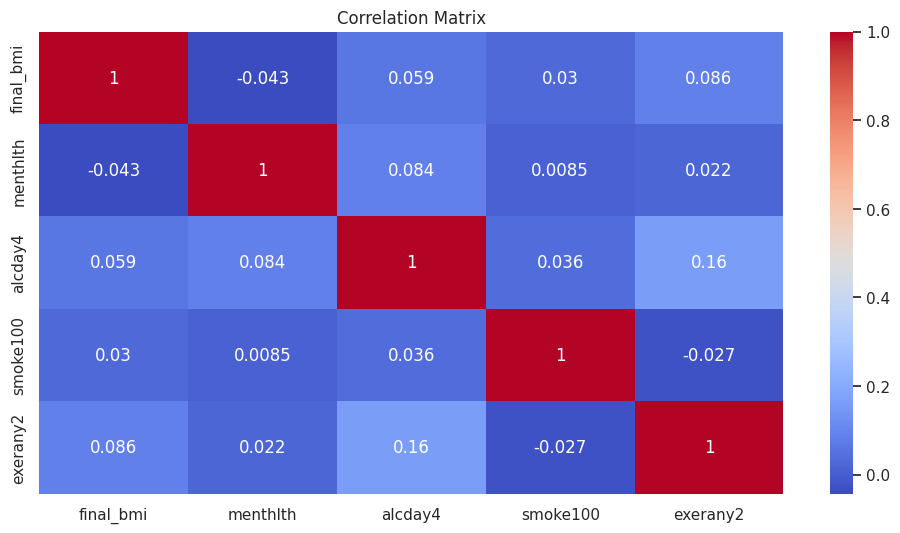

In [13]:
# Compute correlation matrix
corr_matrix = df[["final_bmi", "menthlth", "alcday4", "smoke100", "exerany2"]].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Clustering

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = cluster_ready_df_imputed.copy()

for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    print(f"K={k}: Inertia={km.inertia_:.2f}, Silhouette={silhouette_score(X, km.labels_):.3f}")


K=2: Inertia=52764.48, Silhouette=0.275
K=3: Inertia=45029.06, Silhouette=0.177
K=4: Inertia=39749.85, Silhouette=0.177
K=5: Inertia=36148.88, Silhouette=0.179
K=6: Inertia=33599.58, Silhouette=0.176


We apply both K-Means and DBSCAN clustering on the scaled data.  
First, we use the Elbow Method (inertia) and Silhouette scores to choose the number of clusters, \( K \).

The inertia scores show a lessen return beyond \( K=4 \), indicating limited improvement in model fit.  
Similarly, the silhouette scores peak at \( K=4 \), suggesting it as the optimal number of clusters.  
Therefore, we select \( K=4 \) clusters as a compromise between model fit and parsimony.

In [15]:
from sklearn.cluster import KMeans, DBSCAN

# K-Means
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
clean_df['cluster_km'] = kmeans.labels_
print('K-Means cluster sizes:', pd.Series(kmeans.labels_).value_counts().to_dict())

# DBSCAN
db = DBSCAN(eps=1.5, min_samples=3).fit(X)
clean_df['cluster_db'] = db.labels_
print('DBSCAN labels count:', pd.Series(db.labels_).value_counts().to_dict())

K-Means cluster sizes: {0: 3837, 3: 3008, 1: 2087, 2: 1067}
DBSCAN labels count: {0: 9765, -1: 214, 1: 6, 5: 5, 2: 3, 3: 3, 4: 3}


Experimenting with different hyperparameters for DBSCAN reveals that density-based clustering algorithms are not well-suited for this dataset.

### Cluster Distribution

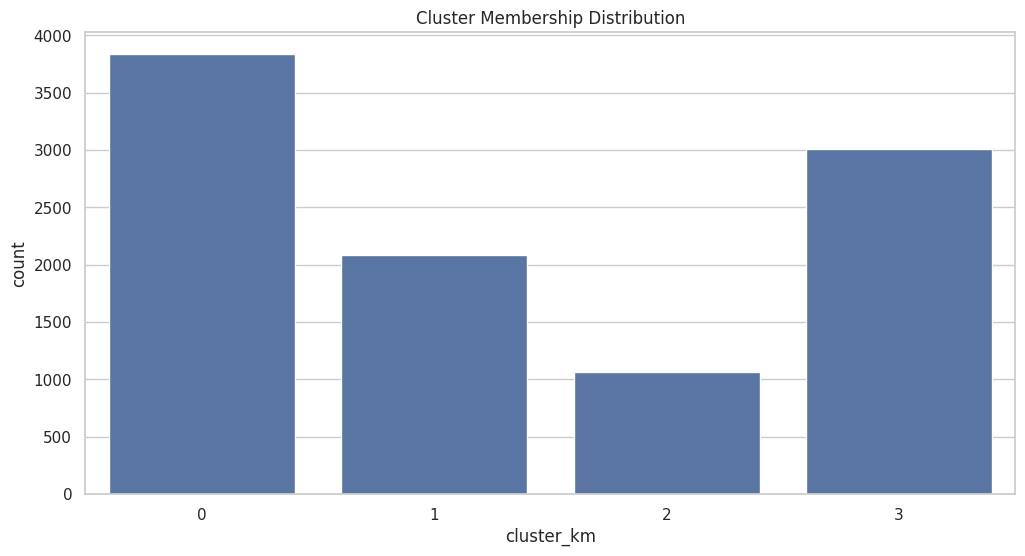

In [16]:
sns.countplot(x='cluster_km', data=clean_df)
plt.title('Cluster Membership Distribution')
plt.show()

### 2D Projection with PCA

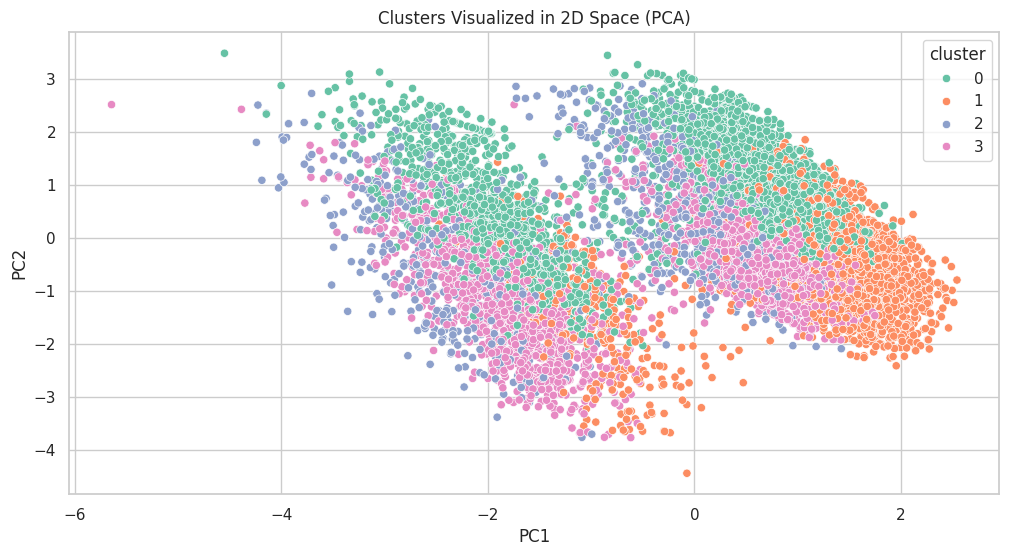

In [17]:
from sklearn.decomposition import PCA
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])
df_pca['cluster'] = clean_df['cluster_km']

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Clusters Visualized in 2D Space (PCA)')
plt.show()


## Statistical Analysis

In [20]:
from scipy.stats import chi2_contingency

conditions = {
    'Hypertension': clean_df['high_blood_pressure']=="Yes",
    'Diabetes':     clean_df['diabetes']=="Yes",
    'HeartDisease': clean_df['heart_attack']=="Yes",
    'Stroke':       clean_df['stroke']=="Yes",
    'Asthma':       clean_df['asthma']=="Yes",
    'Arthritis':    clean_df['arthritis']=="Yes",
    'HighChol':     clean_df['high_cholesterol']=="Yes",
    'SkinCancer':   clean_df['skin_cancer']=="Yes",
    'OtherCancer':  clean_df['other_cancer']=="Yes"
}
for name, cond in conditions.items():
    ct = pd.crosstab(clean_df['cluster_km'], cond)
    chi2, p, _, _ = chi2_contingency(ct)
    print(f"{name}: chi2 p-value = {p:.6g}")


Hypertension: chi2 p-value = 5.42416e-176
Diabetes: chi2 p-value = 3.61944e-94
HeartDisease: chi2 p-value = 3.04587e-40
Stroke: chi2 p-value = 3.63565e-48
Asthma: chi2 p-value = 1.74443e-26
Arthritis: chi2 p-value = 1.90475e-214
HighChol: chi2 p-value = 4.78449e-200
SkinCancer: chi2 p-value = 4.98839e-56
OtherCancer: chi2 p-value = 1.59019e-84


The p-values this small indicate a very strong association between cluster membership and health conditions. In other words, the distribution of health conditions are significantly different across the clusters.

In [21]:
from scipy.stats import f_oneway

groups = [clean_df[clean_df['cluster_km'] == c]['final_bmi'].dropna() for c in sorted(clean_df['cluster_km'].unique())]
_, p_bmi = f_oneway(*groups)
print(f"BMI ANOVA p={p_bmi:.6g}")

BMI ANOVA p=7.02093e-59


- The very small p-value from the BMI ANOVA test shows that BMI distributions differ significantly between clusters.

## Feature Importance

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, clean_df['cluster_km'])
imp = pd.Series(tree.feature_importances_, index=X.columns)
print("Decision Tree importances:")
print(imp.sort_values(ascending=False))

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
logreg.fit(X, clean_df['cluster_km'])
print("\nLogistic Regression coefficients:")
print(pd.DataFrame(logreg.coef_, columns=X.columns))

Decision Tree importances:
alcohol_level                         0.393462
age_numeric                           0.334936
mental_health_days                    0.271602
exercise                              0.000000
final_bmi                             0.000000
smoking                               0.000000
female                                0.000000
income_level                          0.000000
race_White only, Non-Hispanic         0.000000
race_Black only, Non-Hispanic         0.000000
race_Other race only, Non-Hispanic    0.000000
race_Multiracial, Non-Hispanic        0.000000
race_Hispanic                         0.000000
dtype: float64

Logistic Regression coefficients:
   final_bmi  mental_health_days  exercise   smoking  alcohol_level  age_numeric    female  income_level  race_White only, Non-Hispanic  race_Black only, Non-Hispanic  \
0  -0.711209           -4.301729 -0.612641  0.120430      -4.795424     6.779354  0.557987     -2.264486                       0.259782       

The decision tree analysis highlights alcohol consumption level, age, and mental health days as the most important features for distinguishing clusters, while BMI, exercise, smoking, gender, income, and race have negligible importance in this model. In contrast, the logistic regression coefficients suggest that most features—including BMI, alcohol level, age, and mental health—contribute to cluster separation, but the direction and magnitude of their effects vary across clusters. This indicates that while tree-based models focus on a few dominant variables, linear models capture more nuanced, distributed effects among features.

## Reordering Cluster

sort the clusters based on their overall disease burden to create a meaningful progression from low-risk to high-risk lifestyles.

In [23]:
# Calculate disease prevalence by cluster to sort from low-risk to high-risk
disease_conditions = [
    "high_blood_pressure",
    "diabetes",
    "heart_attack",
    "stroke",
    "asthma",
    "arthritis",
    "high_cholesterol",
    "skin_cancer",
    "other_cancer",
]

# Calculate prevalence for each condition by cluster
cluster_disease_summary = {}
for cluster in sorted(clean_df["cluster_km"].unique()):
    cluster_data = clean_df[clean_df["cluster_km"] == cluster]
    prevalences = []

    for condition in disease_conditions:
        prevalence = (cluster_data[condition] == "Yes").mean()
        prevalences.append(prevalence)

    # Calculate average disease burden (mean prevalence across all conditions)
    avg_disease_burden = np.mean(prevalences)
    cluster_disease_summary[cluster] = {
        "avg_disease_burden": avg_disease_burden,
        "individual_prevalences": dict(zip(disease_conditions, prevalences)),
    }

# Sort clusters by average disease burden (low to high risk)
sorted_clusters = sorted(
    cluster_disease_summary.keys(),
    key=lambda x: cluster_disease_summary[x]["avg_disease_burden"],
)

print("Clusters sorted by disease burden (low-risk to high-risk):")
for i, cluster in enumerate(sorted_clusters):
    burden = cluster_disease_summary[cluster]["avg_disease_burden"]
    print(f"Rank {i + 1}: Cluster {cluster} - Average disease burden: {burden:.3f}")

# Create mapping for reordering
cluster_mapping = {
    old_cluster: new_rank for new_rank, old_cluster in enumerate(sorted_clusters)
}
clean_df["cluster_ordered"] = clean_df["cluster_km"].map(cluster_mapping)

print(f"\nCluster mapping: {cluster_mapping}")

print("\nDetailed disease prevalence by ordered cluster:")
for new_rank, old_cluster in enumerate(sorted_clusters):
    print(f"\nCluster {new_rank} (originally cluster {old_cluster}):")
    for condition, prevalence in cluster_disease_summary[old_cluster][
        "individual_prevalences"
    ].items():
        print(f"  {condition}: {prevalence:.3f}")

Clusters sorted by disease burden (low-risk to high-risk):
Rank 1: Cluster 3 - Average disease burden: 0.089
Rank 2: Cluster 1 - Average disease burden: 0.160
Rank 3: Cluster 2 - Average disease burden: 0.212
Rank 4: Cluster 0 - Average disease burden: 0.260

Cluster mapping: {np.int32(3): 0, np.int32(1): 1, np.int32(2): 2, np.int32(0): 3}

Detailed disease prevalence by ordered cluster:

Cluster 0 (originally cluster 3):
  high_blood_pressure: 0.259
  diabetes: 0.073
  heart_attack: 0.018
  stroke: 0.014
  asthma: 0.152
  arthritis: 0.146
  high_cholesterol: 0.097
  skin_cancer: 0.018
  other_cancer: 0.025

Cluster 1 (originally cluster 1):
  high_blood_pressure: 0.427
  diabetes: 0.074
  heart_attack: 0.042
  stroke: 0.024
  asthma: 0.111
  arthritis: 0.291
  high_cholesterol: 0.264
  skin_cancer: 0.096
  other_cancer: 0.114

Cluster 2 (originally cluster 2):
  high_blood_pressure: 0.482
  diabetes: 0.180
  heart_attack: 0.089
  stroke: 0.092
  asthma: 0.251
  arthritis: 0.425
  high

## Visualizations

### Disease prevalence by cluster

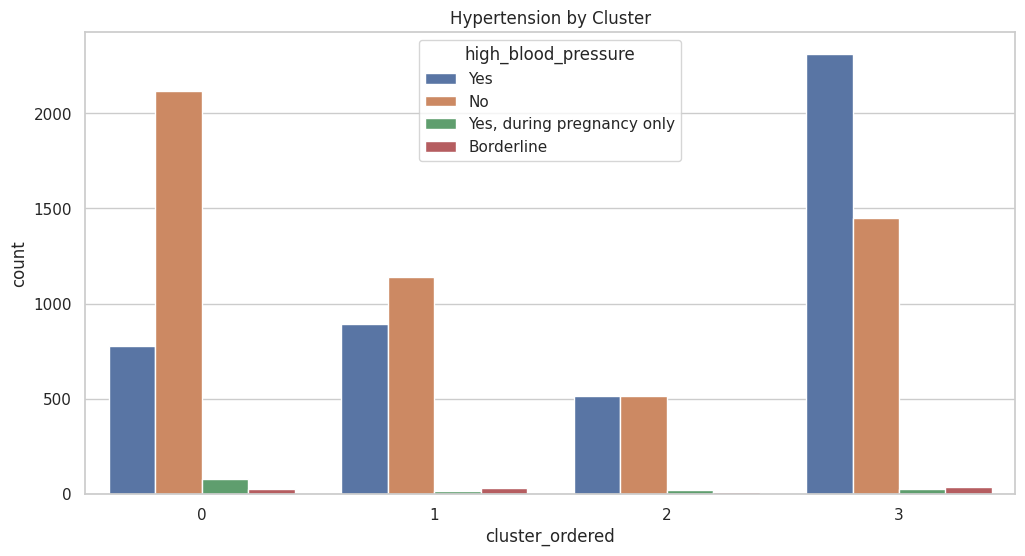

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='cluster_ordered', hue='high_blood_pressure', data=clean_df)
plt.title('Hypertension by Cluster')
plt.show()

This, shows the prevalence of hypertension across different behavioral clusters. Cluster 3 has the highest proportion of individuals with hypertension, while Cluster 0 has the lowest, indicating significant variation in disease risk among clusters.

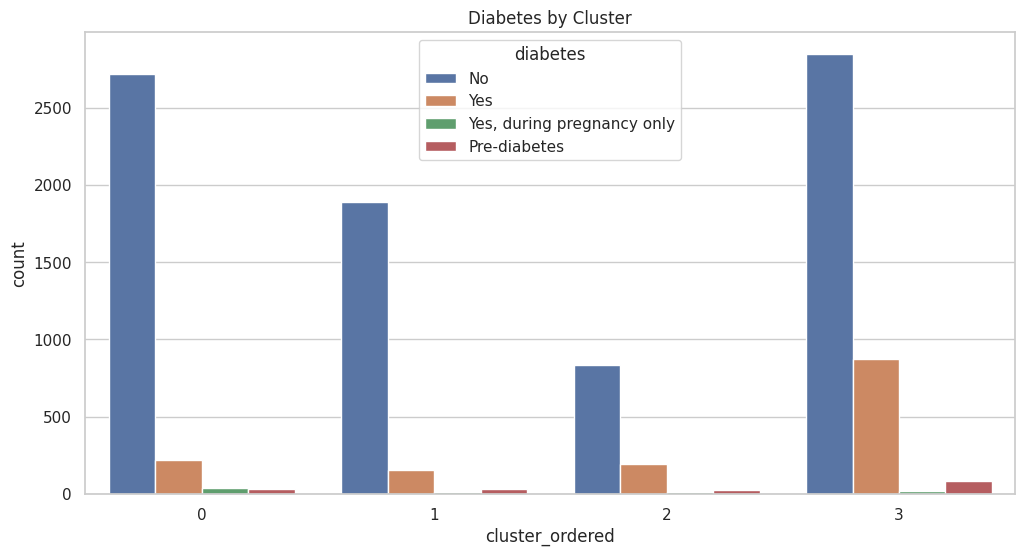

In [25]:
sns.countplot(x='cluster_ordered', hue='diabetes', data=clean_df)
plt.title('Diabetes by Cluster')
plt.show()

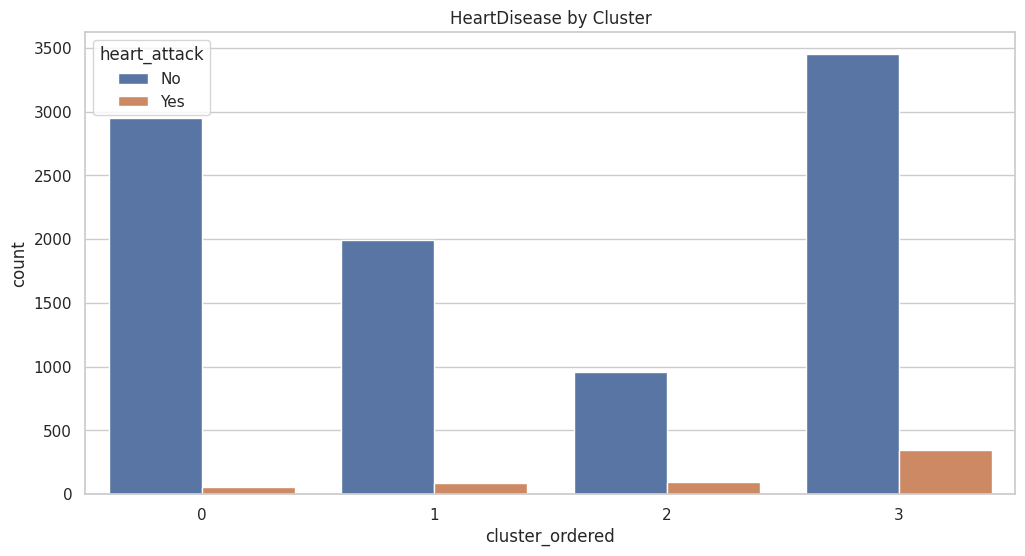

In [26]:
sns.countplot(x='cluster_ordered', hue='heart_attack', data=clean_df)
plt.title('HeartDisease by Cluster')
plt.show()

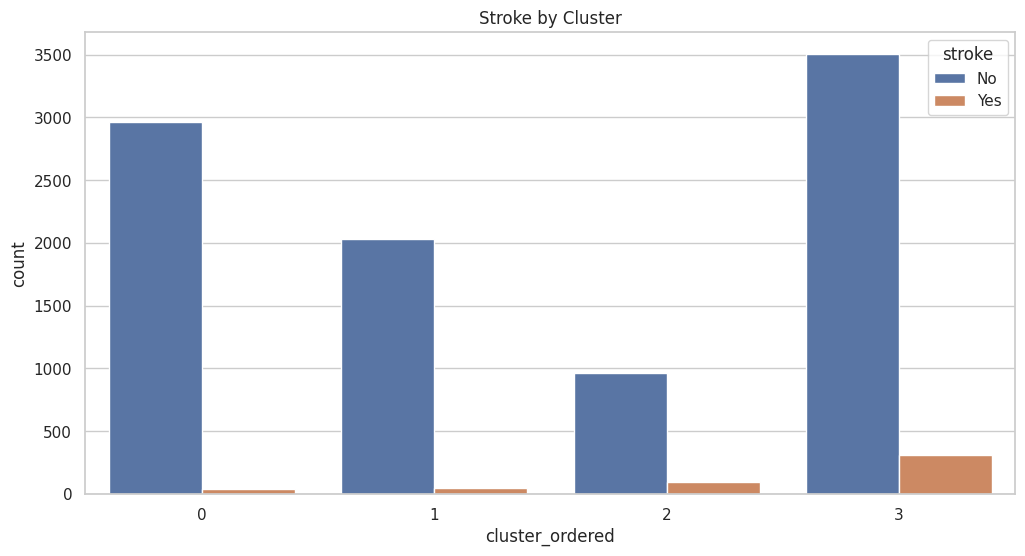

In [27]:
sns.countplot(x='cluster_ordered', hue='stroke', data=clean_df)
plt.title('Stroke by Cluster')
plt.show()

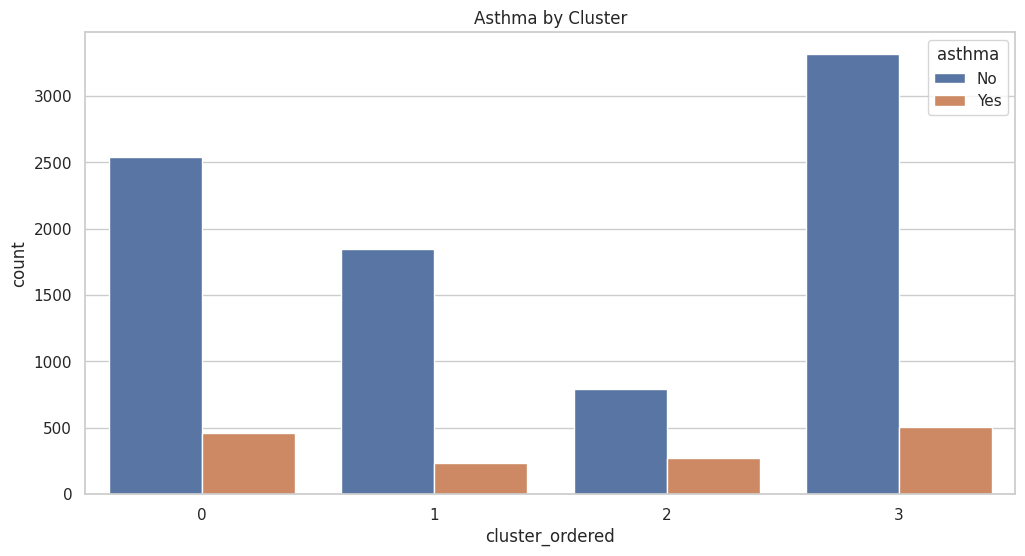

In [28]:
sns.countplot(x='cluster_ordered', hue='asthma', data=clean_df)
plt.title('Asthma by Cluster')
plt.show()

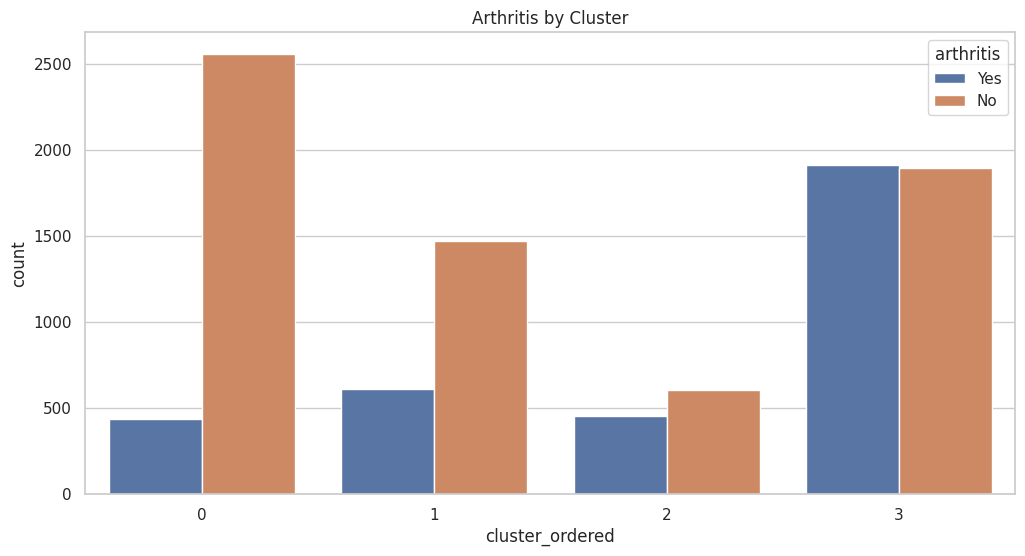

In [29]:
sns.countplot(x='cluster_ordered', hue='arthritis', data=clean_df)
plt.title('Arthritis by Cluster')
plt.show()

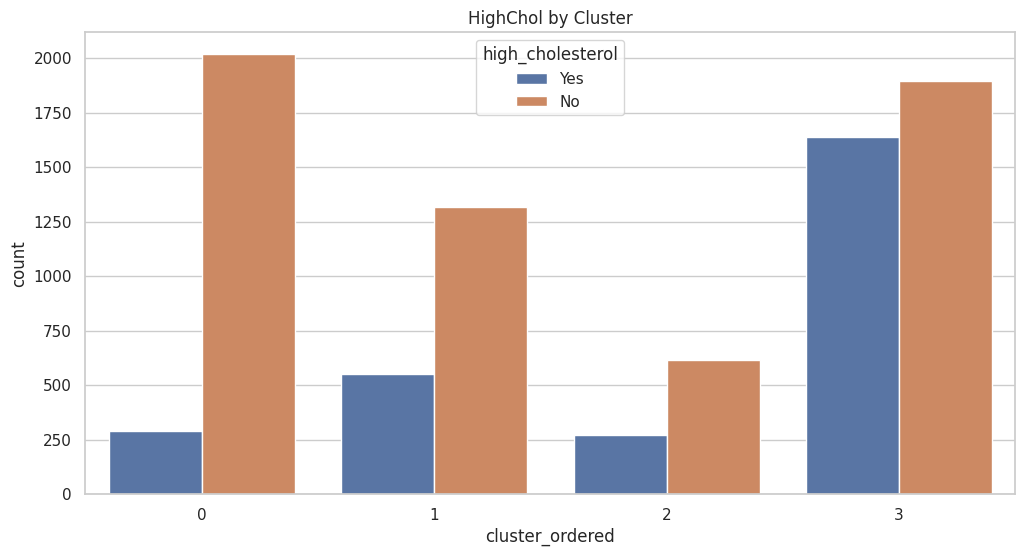

In [30]:
sns.countplot(x='cluster_ordered', hue='high_cholesterol', data=clean_df)
plt.title('HighChol by Cluster')
plt.show()

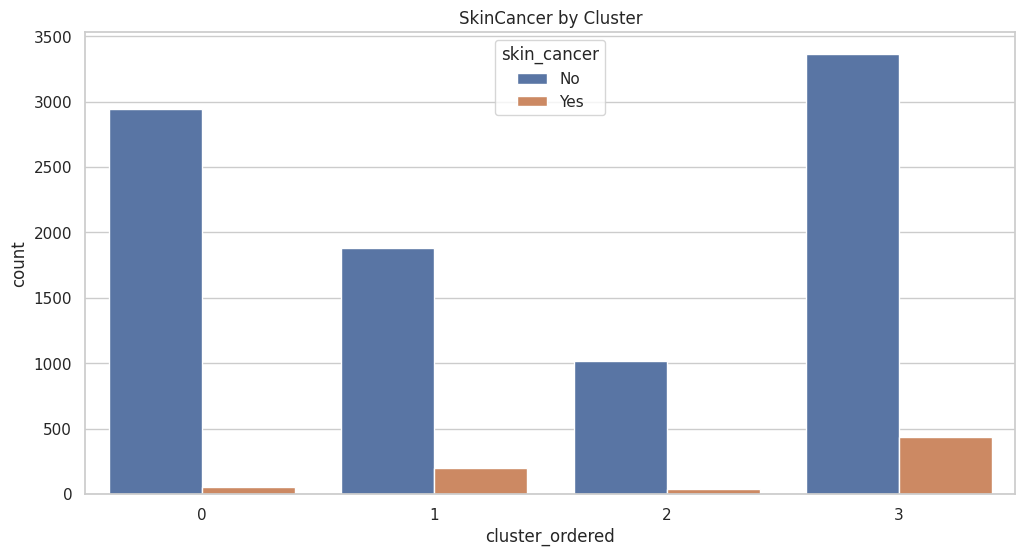

In [31]:
sns.countplot(x='cluster_ordered', hue='skin_cancer', data=clean_df)
plt.title('SkinCancer by Cluster')
plt.show()

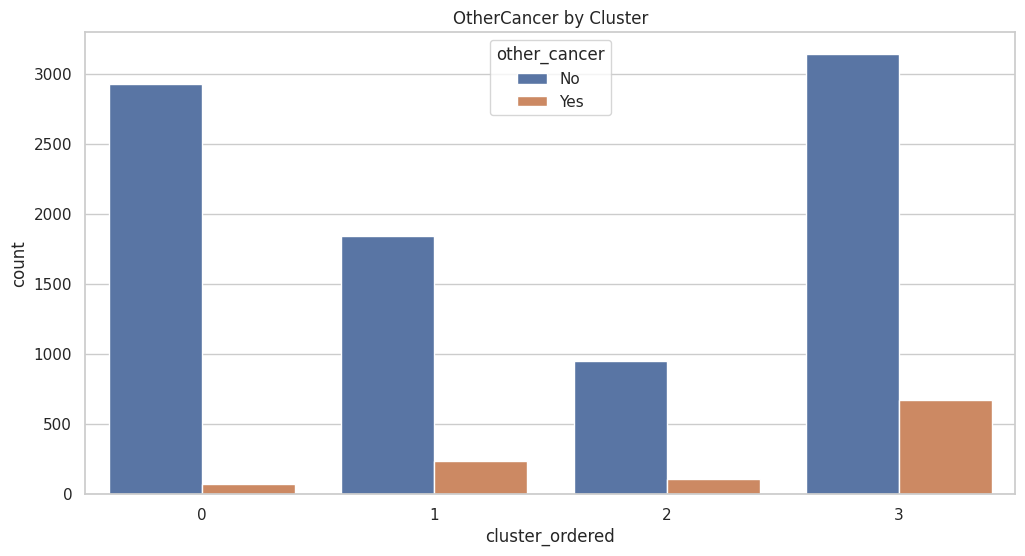

In [32]:
sns.countplot(x='cluster_ordered', hue='other_cancer', data=clean_df)
plt.title('OtherCancer by Cluster')
plt.show()